In [29]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib import animation
from scipy.spatial import distance
from IPython.display import HTML
from copy import deepcopy
import itertools as it

In [3]:
def generate_points(n_points, radius, circle_centre=[0.0, 0.0]):
    h, k = circle_centre
    angles = np.random.uniform(0, 2 * np.pi, n_points)  # Random angles
    r = np.sqrt(np.random.uniform(0, 1, n_points)) * radius  # Random radius with correct distribution
    x = r * np.cos(angles) + h
    y = r * np.sin(angles) + k
    return np.column_stack((x, y))  # Return as Nx2 array


def move_points(radius, points, angles, distances, circle_centre=[0.0, 0.0]):
    # Convert angle to radians
    angles += 0.0001
    angles_rad = np.radians(angles)
    
    # Calculate the movement vector components
    dxs = distances * np.cos(angles_rad)
    dys = distances * np.sin(angles_rad)

    # Create a movement vector for all points
    displacement_vectors = np.array([dxs, dys]).T

    # Displace the points
    displaced_points = points + displacement_vectors

    displaced_points = np.vstack([outside_circle_displacement(radius, points[i], displaced_points[i]) for i in range(points.shape[0])])
    
    return displaced_points

def inside_circle(radius, points, circle_centre=[0.0, 0.0]):
    points = np.array(points)
    h, k = circle_centre
    x, y = np.hsplit(points, 2)
    
    # Calculate the squared distance from the point to the circle center
    dist_squared = (x - h) ** 2 + (y - k) ** 2
    radius_squared = radius ** 2

    # Check if the point is inside or on the circle
    result = dist_squared <= radius_squared
    return result.flatten()

def circle_line_intersection(radius, point1, point2, circle_centre=[0.0, 0.0]):
    h, k = circle_centre
    x1, y1 = point1
    x2, y2 = point2

    # Calculate slope (m) and intercept (b) of the line
    if x2 - x1 == 0:  # vertical line case
        return []  # A vertical line will not intersect unless it's also at the circle's horizontal level

    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1

    # Coefficients of the quadratic equation Ax^2 + Bx + C = 0
    A = 1 + m**2
    B = 2 * (m * (b - k) - h)
    C = (h**2 + (b - k)**2 - radius**2)

    # Calculate the discriminant
    D = B**2 - 4 * A * C

    intersection_points = []

    if D >= 0:  # There are intersections
        # Two possible intersection points if D > 0, one if D = 0
        sqrt_D = np.sqrt(D)

        # Compute both x-coordinates
        x_intersect1 = (-B + sqrt_D) / (2 * A)
        y_intersect1 = m * x_intersect1 + b
        intersection_points.append((x_intersect1, y_intersect1))

        if D > 0:  # Only compute the second intersection point if D > 0
            x_intersect2 = (-B - sqrt_D) / (2 * A)
            y_intersect2 = m * x_intersect2 + b
            intersection_points.append((x_intersect2, y_intersect2))

    return np.array(intersection_points).astype(np.double)

def vector_points(point1, point2):
    x1, y1 = point1
    x2, y2 = point2

    # Calculate the vector components
    dx = x2 - x1
    dy = y2 - y1

    return np.array([dx, dy]).astype(np.double)


def outside_circle_displacement(radius, point_1, point_2, circle_centre=[0.0, 0.0]):
    point_2_outside = ~inside_circle(radius, point_2)
    if point_2_outside:
        cli_array = circle_line_intersection(radius, point_1, point_2)
        cli = np.split(cli_array, 2, axis=0)
        cli = [i.flatten() for i in cli]
        cli_distance = [distance.euclidean(i, point_2) for i in cli]
        new_orig = cli[np.argmax(cli_distance)]
        left_disp_orig = cli[np.argmin(cli_distance)]
        left_disp_vec = vector_points(left_disp_orig, point_2)
        point_3 = new_orig + left_disp_vec
        return point_3
    else:
        return point_2

In [4]:
n_points = 500
circle_centre = [0,0]
radius = 7.5
points = generate_points(n_points, radius)

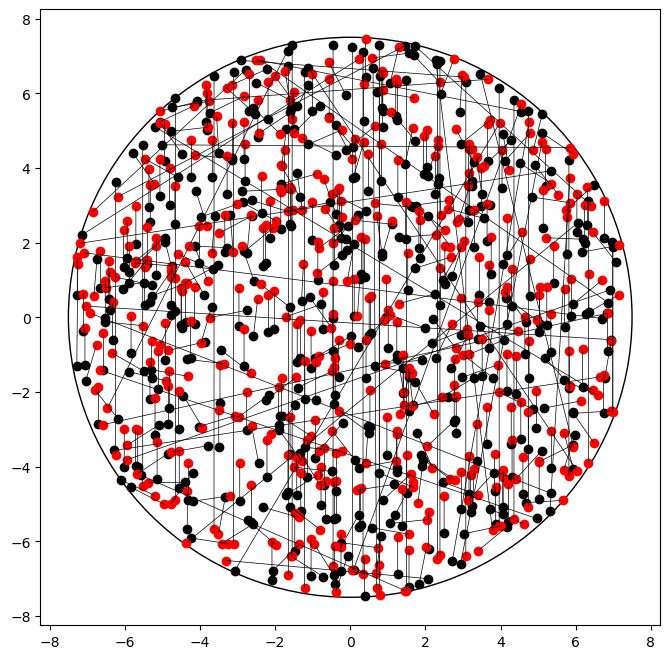

In [61]:
f, ax = plt.subplots(1,1, figsize=(8,8))

circle = plt.Circle(
    (0, 0), radius=radius, edgecolor="black",
    lw=1, facecolor="none"
)

# angles = np.repeat(90.0, n_points) + 0.001
angles = np.hstack([np.repeat(90.0, n_points//2), np.random.uniform(0.0, 360.0, n_points - n_points//2)])
# angles = np.random.uniform(0.0, 360.0, n_points)

distances = np.repeat(1, n_points)
move_points(radius, points, angles, distances)
points_moved = move_points(radius, points, angles, distances)

ax.add_patch(circle)
ax.scatter(points[:,0], points[:,1], c="black")
ax.scatter(points_moved[:,0], points_moved[:,1], c="red")
for i in range(n_points):
    ax.plot([points[i,0], points_moved[i,0]], [points[i,1], points_moved[i,1]], lw=0.5, c="black")

In [62]:
distances = np.repeat(0.05, n_points)
angles = np.hstack([np.repeat(0.0, n_points//3), np.repeat(180.0, n_points//3), np.random.uniform(0.0, 360.0, n_points - (n_points//3)*2)])

positions = []
copy_points = deepcopy(points)
for i in range(300):
    copy_points = deepcopy(copy_points)
    copy_points = move_points(radius, copy_points, angles, distances)
    positions.append(copy_points)

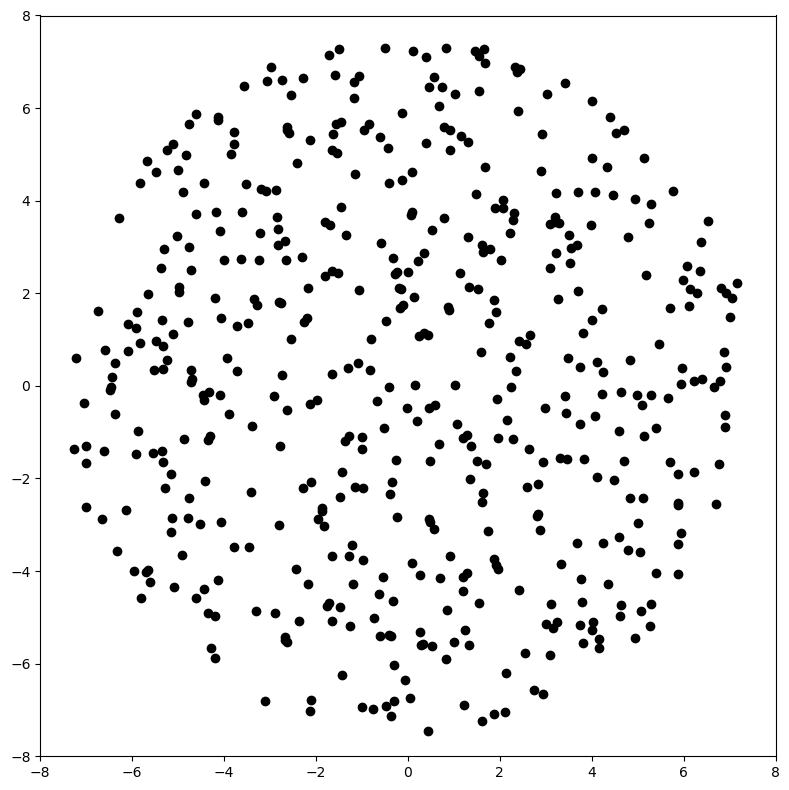

In [65]:
f, ax = plt.subplots(1,1, figsize=(8,8))

# circle = plt.Circle(
#     (0, 0), radius=radius, edgecolor="black",
#     lw=1, facecolor="none"
# )

# ax.add_patch(circle)
scat = ax.scatter([], [], c="black");

ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)

plt.tight_layout()
def animate(i):
    scat.set_offsets(positions[i])
    return (scat,)

ani = animation.FuncAnimation(f, animate, repeat=True, frames=len(positions) - 1, interval=10)

HTML(ani.to_html5_video())

In [6]:
def fill_stuff(key, value, amount):
    if key == "noise":
        return np.random.uniform(0.0, 360.0, amount)
    else:
        return np.repeat(value, amount)

In [267]:
# generate positions
n_frames = 200
dot_life = 20
interleaved_sets = 2

settings = {
    "right": [1/8, 0.0, 0.05],
    "left": [1/8, 180.0, 0.05],
    "noise": [6/8, 0.0, 0.05]
}

# body of the function

frames_per_set = [int(np.round(n_frames / interleaved_sets, 0)) for i in range(interleaved_sets)]
frames_per_set[-1] = n_frames - sum(frames_per_set[:-1])

i_sets = []
for i_set in range(interleaved_sets):
    dots_per_cond = [int(n_points * settings[k][0]) for k in settings.keys()]
    dots_per_cond[-1] = n_points - sum(dots_per_cond[:-1])
    dots_per_cond = {k: dots_per_cond[i] for i, k in enumerate(settings.keys())}
    angles = np.hstack([fill_stuff(k, settings[k][1], dots_per_cond[k]) for k in settings.keys()])
    distances = np.hstack([fill_stuff("", settings[k][2], dots_per_cond[k]) for k in settings.keys()])
    positions = []
    current_am_frames = 0
    while True:
        points = generate_points(n_points, radius)
        copy_points = deepcopy(points)
        for i in range(dot_life):
            copy_points = deepcopy(copy_points)
            copy_points = move_points(radius, copy_points, angles, distances)
            positions.append(copy_points)
            current_am_frames += 1
            if current_am_frames == frames_per_set[i_set]:
                break
        if current_am_frames == frames_per_set[i_set]:
            break
    positions = np.array(positions)
    i_sets.append(positions)

positions_all = np.concat(i_sets, axis=0)

# positions_all = np.empty((int(np.sum([i.shape[0] for i in i_sets])), *i_sets[0].shape[1:]))
# try:
#     for i_x, i_s in enumerate(i_sets):
#         positions_all[i_x::interleaved_sets] = i_s
# except:
#     for i_x, i_s in enumerate(i_sets[::-1]):
#         positions_all[i_x::interleaved_sets] = i_s

In [59]:
def gen_positions(n_points, radius, settings, dot_life, n_frames, circle_centre=[0.0, 0.0]):
    dots_per_cond = [int(n_points * settings[k][0]) for k in settings.keys()]
    dots_per_cond[-1] = n_points - sum(dots_per_cond[:-1])
    dots_per_cond = {k: dots_per_cond[i] for i, k in enumerate(settings.keys())}
    angles = np.hstack([fill_stuff(k, settings[k][1], dots_per_cond[k]) for k in settings.keys()])
    distances = np.hstack([fill_stuff("", settings[k][2], dots_per_cond[k]) for k in settings.keys()])
    positions = []
    current_am_frames = 0
    while True:
        points = generate_points(n_points, radius)
        copy_points = deepcopy(points)
        for i in range(dot_life):
            copy_points = deepcopy(copy_points)
            copy_points = move_points(radius, copy_points, angles, distances)
            positions.append(copy_points)
            current_am_frames += 1
            if current_am_frames == n_frames:
                break
        if current_am_frames == n_frames:
            break

    return np.array(positions)



In [60]:
# generate positions
n_frames = 200
dot_life = 3


settings = {
    "right": [0.1, 0.0, 0.05],
    "left": [0.1, 180.0, 0.05],
    "noise": [0.8, 0.0, 0.05]
}



positions_0 = gen_positions(n_points, radius, settings, 200, n_frames)
positions_1 = gen_positions(n_points, radius, settings, 200, n_frames)
positions_2 = gen_positions(n_points, radius, settings, 200, n_frames)

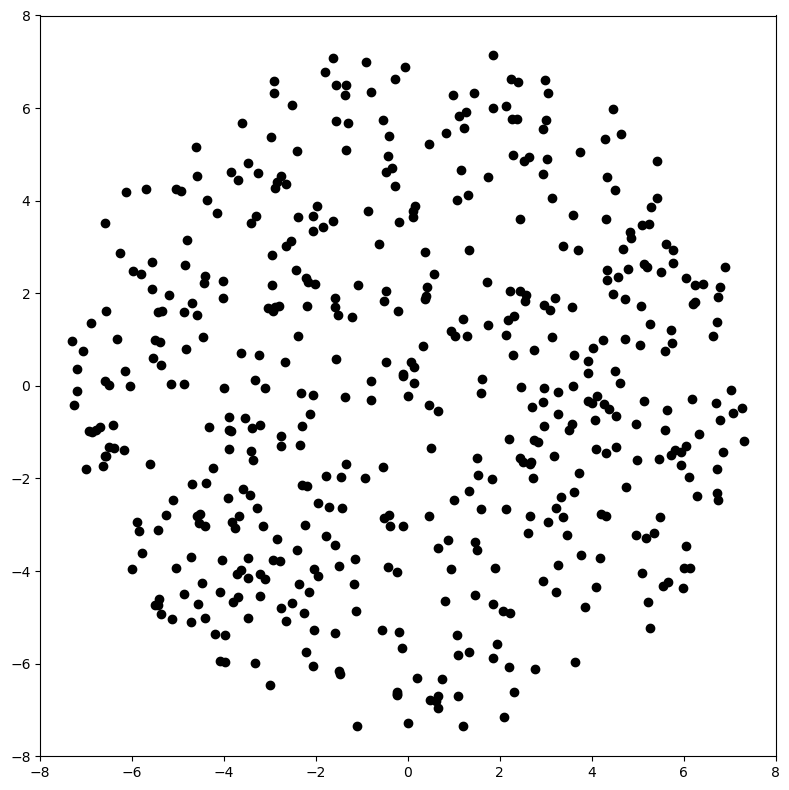

In [55]:
f, ax = plt.subplots(1,1, figsize=(8,8))

scat = ax.scatter([], [], c="black")

ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)

plt.tight_layout()
def animate(i):
    scat.set_offsets(positions[i])
    return (scat,)

ani = animation.FuncAnimation(f, animate, repeat=True, frames=len(positions), interval=13.3)

HTML(ani.to_html5_video())

In [65]:
positions_0[3::3].shape

(66, 500, 2)